### Load ABF Files

In [1]:
%load_ext autoreload
import sys
sys.path.append("../src")
import pyabf
import slopeTools
import abfTools
import plotTools
import statsTools
import numpy as np
import matplotlib.pyplot as plt

abfFilePaths = [
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804007.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804024.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804030.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804043.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804048.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804060.abf", 
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20804066.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805008.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805029.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20805035.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20811011.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20811021.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20817012.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20831011.abf",
    R"X:/Data/C57/TGOT on PVT/2020-07-28 10nM TGOT on PVT/20831017.abf"
]


### Get Holding Current and Break Data into Segments

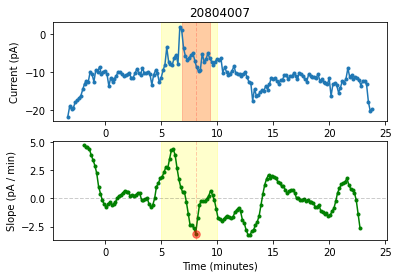

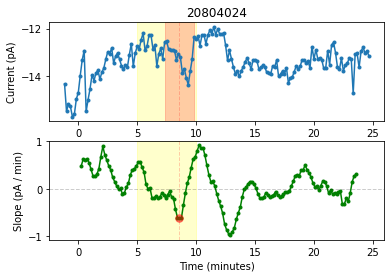

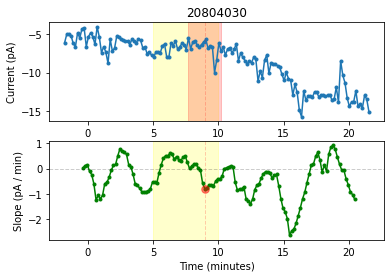

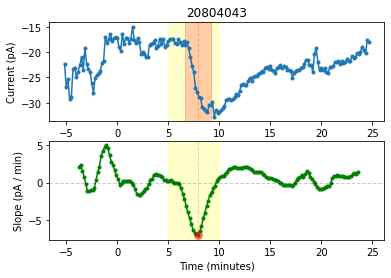

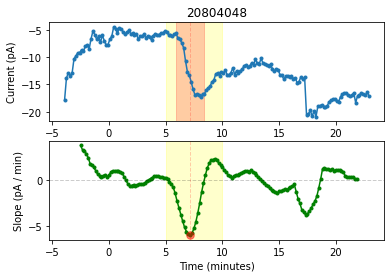

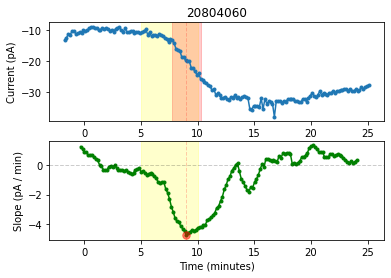

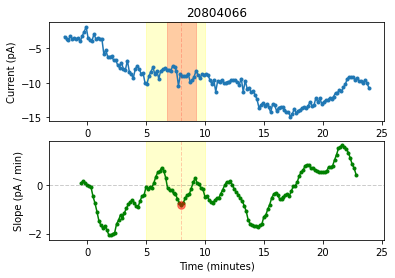

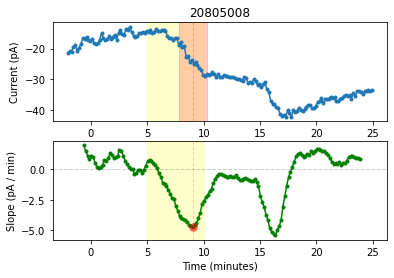

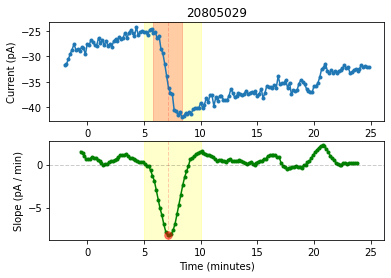

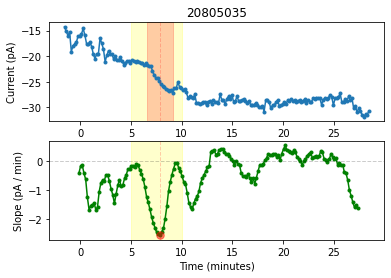

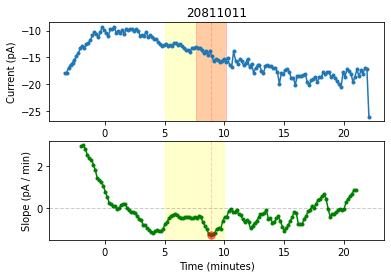

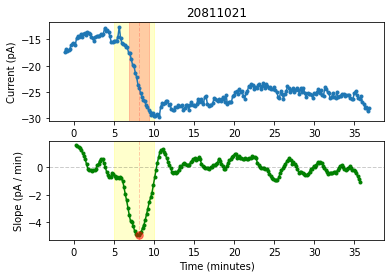

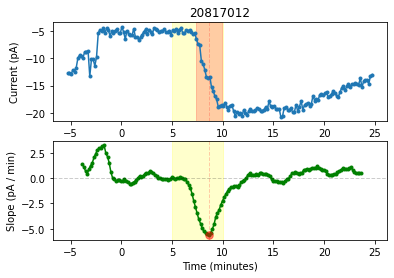

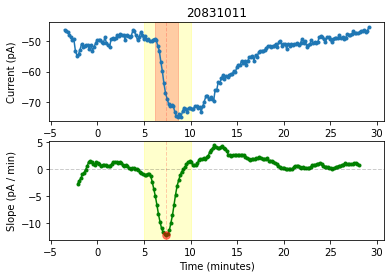

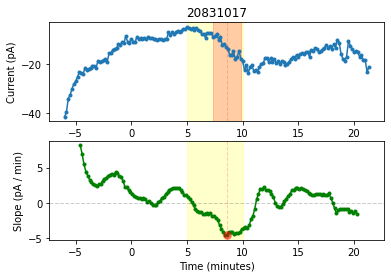

In [2]:
sweepPeriod = 10/60
windowSize = 15
slopesBaseline =[]
slopesDrug =[]
currentsBaseline = []
currentsDrug = []
abfIDs = []

for abfFilePath in abfFilePaths:
    # get the tag-aligned raw data of holding current and time
    currentsRaw, timesRaw, abfID = abfTools.meanIhold(abfFilePath)
    abfIDs.append(abfID)
    
    # Get the mean current during baseline and drug application
    currentsBaseline.append(statsTools.rangeMean(currentsRaw, timesRaw, 3, 5))
    currentsDrug.append(statsTools.rangeMean(currentsRaw, timesRaw, 6, 10))
    
    # get slopes of each segments
    currentsSegs = statsTools.getMovingWindowSegments(currentsRaw, windowSize)
    slopes = slopeTools.getAllSegmentSlopes(currentsSegs, sweepPeriod)
    tagTime = abfTools.getFirstTagTime(abfFilePath)
    slopeTimeOffset = windowSize * sweepPeriod / 2-(tagTime-5)
    timesSegs = np.arange(len(slopes))*sweepPeriod + slopeTimeOffset

    # rave function
    slopeBaseline = statsTools.rangeMean(slopes,timesSegs,3,5) # the mean slope between 3-5min was used as the baseline slope
    slopeDrug = statsTools.rangeMin(slopes,timesSegs,5,10) # the minimal slope between 5-10min was used as the drug slope
    slopesBaseline.append(slopeBaseline)
    slopesDrug.append(slopeDrug)

    # find the time point when the minimal slope happens
    indexslopeDrug = slopes.index(slopeDrug)
    peakSlopeTime = timesSegs[indexslopeDrug]
    #print(f"the maximal negative slope is {slopeDrug} at {peakSlopeTime} min (index {indexslopeDrug})")

    # plot current & slope vs time
    plt.figure()
    ax1 = plt.subplot(211)
    plotTools.plotCurrentOverTimeAndLabelPeakSlope(currentsRaw, timesRaw, peakSlopeTime, windowSize)
    plt.title(abfID)

    ax2 = plt.subplot(212, sharex=ax1)
    plotTools.plotSlopesOverTimeAndMarkpeakSlope(slopes, timesSegs, peakSlopeTime, slopeDrug)
    
    plt.show()




### Plot slopes before and during drug application

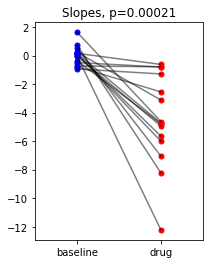

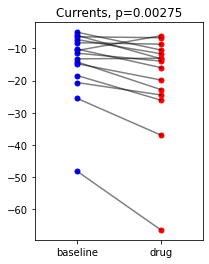

In [3]:
plotTools.plotPairs(slopesBaseline, slopesDrug, "Slopes")
plotTools.plotPairs(currentsBaseline, currentsDrug, "Currents")

### Report responders and non-responders based on the change of slope
1. Change of slope is larger than the defined threshold.
2. The delta holding current during drug application period is less than 0.

In [4]:
slopeThreshold = -1.5 # peak negative slope must exceed this value to be a responder
# create lists of responders and non-responders
responders=[]
nonResponders=[]
for i in range(len(abfIDs)):
    abfID = abfIDs[i]
    drugEffectSlope = slopesDrug[i] - slopesBaseline[i]
    cellHasSteepNegativeSlope = drugEffectSlope <= slopeThreshold
    cellGoesNegativeOverTime = currentsDrug[i]-currentsBaseline[i] < 0
    if cellHasSteepNegativeSlope and cellGoesNegativeOverTime:
        responders.append(abfID)
    else:
        nonResponders.append(abfID)

responseRate = round(len(responders)/len(abfIDs)*100, 3)
print(f"Responders = {len(responders)}")
print(f"Non-Responders = {len(nonResponders)}")
print(f"Response rate = {responseRate}%")

Responders = 10
Non-Responders = 5
Response rate = 66.667%


In [5]:
print("Responders: " + ", ".join(responders))
print("Non-Responders: " + ", ".join(nonResponders))

Responders: 20804043, 20804048, 20804060, 20805008, 20805029, 20805035, 20811021, 20817012, 20831011, 20831017
Non-Responders: 20804007, 20804024, 20804030, 20804066, 20811011
